<font size = 10>This notebook is a tool to Build a graph for spatio-temporal anomaly detection in 5G networks </font>

`First: we need those import`

In [1]:
import os
import random
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import time
import re
import Tools_first_step as tfs
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

The threashold is required to select when we want an edge or not using this equation:

$$   
    A_{i,j}= 
    \left\{
    \begin{array}{ll}
    0 & \text{if  ~ } S_{i,j} \leq T \\
    1 & \text{if ~} S_{i,j} > T 
    \end{array}
    \right.
     $$

The L is used in a Lambda model in the equation: $$  S_{i,j}=\lambda |Corr(x_i,x_j)| + (1-\lambda)|Cosim(x_i, x_j)| $$ (ref. in the article XXX)

In [2]:
threashold=0.90
L=0.5

This is all the path of file we need in this notebook

In [3]:
path_dataset='/home/killian/Documents/Data/dataset_end_total_preprocessed.csv'
doc_path="truc.txt"
matrix_correlation_path='/home/killian/Documents/Data/corr_matrice.csv' #not mandatory, we can also compute directly

> ## I) Load the dataset

In [4]:
df=pd.read_csv(path_dataset, nrows=20) 
#nrows can be used or not
#depending if we need to calculate the correlation matrix or import it
columns=df.columns

In [5]:
#verify the dataset :
print(df.shape)
col_to_keep=tfs.rmv_Unnamed(df.columns)
df=df[col_to_keep]
print(df.shape)

(20, 1058)
(20, 1057)


# II) This part will generate a graph with our data

> ### For this, we need to tokenize the feature name

In [6]:
name_columns=df.columns
print(tfs.estimate_total_number_of_word(name_columns))
number_complet=tfs.estimate_total_number_of_word(name_columns)
print(tfs.find_frequence_of_words(name_columns)[1])

8656
['node', 'context', 'switches', 'total', 'server', '1', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="0"', '', 'cpu="1"', 'cpu="10"', 'cpu="11"', 'cpu="12"', 'cpu="13"', 'cpu="14"', 'cpu="15"', 'cpu="16"', 'cpu="17"', 'cpu="18"', 'cpu="19"', 'cpu="2"', 'cpu="20"', 'cpu="21"', 'cpu="22"', 'cpu="23"', 'cpu="24"', 'cpu="25"', 'cpu="26"', 'cpu="27"', 'cpu="28"', 'cpu="29"', 'cpu="3"', 'cpu="30"', 'cpu="31"', 'cpu="4"', 'cpu="5"', 'cpu="6"', 'cpu="7"', 'cpu="8"', 'cpu="9"', 'seconds', 'mode="idle"', 'mode="iowait"', 'mode="softirq"', 'mode="user"', 'mode="system"', 'disk', 'io', 'now', 'device="dm-0"', 'device="sda"', 'time', 'weighted', 'read', 'bytes', 'reads', 'completed', 'merged', 'writes', 'entropy', 'available', 'bits', 'filefd', 'allocated', 'filesystem', 'avail', 'device="/dev/mapper/nation--vg-root"', 'fstype="ext4"', 'mountpoint="/"', 'device="tmpfs"', 'fstype="tmpfs"', 'mountpoint="/run"', 'files', 'free', 'forks', 'hwmon', 'temp', 'celsius', 'chip="platform', 'coretemp', '

In [7]:
tfs.split_all(name_columns)

[['node', 'context', 'switches', 'total', 'server', '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="0"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="1"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="10"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="11"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="12"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="13"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="14"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="15"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'cpu="16"',
  '',
  'server',
  '1'],
 ['node',
  'cpu',
  'scaling',
  'frequency',
  'hertz',
  'c

In [8]:
dico_all_word=tfs.find_frequence_of_words(name_columns)[1]
dico2=tfs.find_frequence_of_words(name_columns)[0]

In [9]:
import nltk

new_dico_all_word=tfs.cleaning_txt_documentation(doc_path)
#print(new_dico_all_word[100:103])

In [10]:
#we need to get every word, including those that are only in the dataset, so we just add the column name at the end of the description file to be sure to have it
final_dictionnary=new_dico_all_word+tfs.split_all(name_columns)

> ### Using word2vec, we transform our token, then features names into vectors

Instead, we will probably have to try BERT with the time ! BERT seams better today, but we have to give context for this one

In [11]:
from gensim.models import Word2Vec


model = Word2Vec(sentences=final_dictionnary, vector_size=25, min_count=1, workers=4, epochs=50)
model_light= Word2Vec(sentences=final_dictionnary, vector_size=3, min_count=1, workers=4, epochs=50)

In [12]:
#if we need comparison; here we are only using column names
from gensim.models import Word2Vec


model = Word2Vec(sentences=tfs.split_all(name_columns), vector_size=25, min_count=1, workers=4, epochs=50)
model_light= Word2Vec(sentences=tfs.split_all(name_columns), vector_size=3, min_count=1, workers=4, epochs=50)
#model.save("word2vec.model")

In [13]:
a=tfs.number_a_word_in_doc(name_columns, dico2, dico_all_word)
print(a)

name : node
sequence: ['node', 'context', 'switches', 'total', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="0"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="1"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="10"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="11"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="12"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="13"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="14"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="15"', '', 'server', '1']
name : node
sequence: ['node', 'cpu', 'scaling', 'frequency', 'hertz', 'cpu="16"', '', 'server', '1']
name :

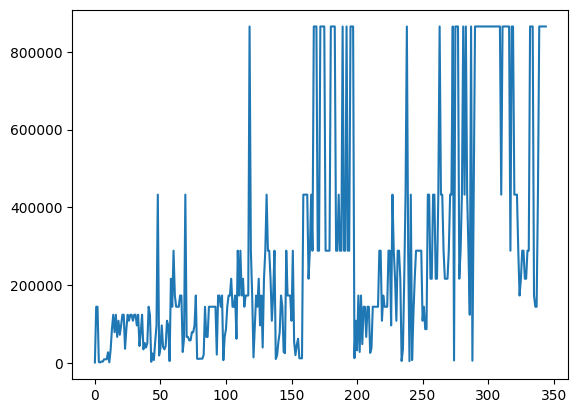

In [14]:
score_for_each=[]
for word, freq in dico2.items():
    a=tfs.TF_new_version(word, dico2, number_complet)
    score_for_each.append(a)

plt.plot(score_for_each)

> ### Now we need to use a similarity score to evaluate the difference between two features names

In [15]:

sequence1 = model.wv['scaling']
sequence2 = model.wv['collector']
similarity = tfs.cosine_similarity(sequence1, sequence2)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.12510814


In [16]:
a,b=tfs.score_similarity_current(name_columns, model_light)
print(b)

{'node_cpu_scaling_frequency_hertz{cpu="0"}_server_1': array([ 8141.423,  9159.484, 16160.111], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="1"}_server_1': array([ 8371.488, 11236.791, 17656.484], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="10"}_server_1': array([ 9946.543, 13616.059, 22743.232], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="11"}_server_1': array([12490.004, 14074.059, 25964.168], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="12"}_server_1': array([10936.012, 12893.792, 22534.924], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="13"}_server_1': array([11973.387, 13838.191, 25346.598], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="14"}_server_1': array([ 9639.252, 13871.532, 21831.607], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="15"}_server_1': array([10620.34 , 15359.005, 25241.898], dtype=float32), 'node_cpu_scaling_frequency_hertz{cpu="16"}_server_1': array([ 9783.354, 12683.247, 21511.713], dtype=flo

In [17]:
print(a[('node_cpu_scaling_frequency_hertz{cpu="0"}_server_1','node_cpu_scaling_frequency_hertz{cpu="5"}_server_1')])#'process_open_fds_server_6')])#)])

0.999927


In [18]:
nodes=name_columns

cosine_similarities, vectores_places=tfs.score_similarity_current(name_columns, model_light)
cosine_similarities_25d, vectores_places_25d=tfs.score_similarity_current(name_columns, model)


> ### Once this is done, we can plot the first graph

In [19]:
#tfs.plot_graph_v1(cosine_similarities,threashold,vectores_places)

In [20]:
#xe,ye,ze, all_edges=tfs.get_edges_v3(cosine_similarities,threashold, vectores_places, "server")
#print(all_edges)


In [21]:
#import Tools_first_step as tfs
#before: 233070
xe,ye,ze, all_edges=tfs.get_edges_topK(cosine_similarities,threashold, vectores_places, "server", topK=100)

 total amount of edges : 100688


In [22]:
#print(all_edges[0][0][0])

In [23]:
#medium_node_number=tfs.get_medium_number_of_edges(all_edges)
#print(medium_node_number)

In [24]:
#nb=tfs.get_distribution_number_of_edges_per_nodes("server",cosine_similarities,threashold, vectores_places)
#mid distrib not final !

> ### We can even plot part of the graph that contains a specific word (in the dictionnary of word in all the features)

In [25]:
#tfs.plot_only_part_data(cosine_similarities,threashold,vectores_places,"server_1")

# III) This part will propose to modify the edges selections, by using also the correlation matrix

In [26]:
#corr_mat=df.corr()

#Here we decide to load the correlation instead of compute it

corr_mat=np.genfromtxt(matrix_correlation_path, delimiter=',')
corr_mat=pd.DataFrame(corr_mat, columns=df.columns)
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[1]):
        corr_mat.iloc[j,i]=corr_mat.iloc[i,j]

np.fill_diagonal(corr_mat.values, 1)

In [27]:
corr_mat.index=df.columns
corr_mat.head()

,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_times_squeezed_total{cpu=""2""}_server_6","node_softnet_times_squeezed_total{cpu=""3""}_server_6","node_softnet_times_squeezed_total{cpu=""4""}_server_6","node_softnet_times_squeezed_total{cpu=""5""}_server_6","node_softnet_times_squeezed_total{cpu=""6""}_server_6",node_timex_pps_shift_seconds_server_6,node_timex_pps_stability_exceeded_total_server_6,process_resident_memory_bytes_server_6,process_start_time_seconds_server_6,"promhttp_metric_handler_errors_total{cause=""encoding""}_server_6"
node_context_switches_total_server_1,1.000000,-0.076855,-0.016990,-0.080600,-0.124550,-0.072527,-0.121365,-0.073760,-0.123489,-0.064731,...,0.320529,0.320529,0.320530,0.320529,0.320529,0.320145,NaN,-0.319324,-0.319337,0.000700
"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1",-0.076855,1.000000,0.002885,0.011871,0.015776,0.008588,0.017287,0.013069,0.020237,0.086501,...,-0.034753,-0.034753,-0.034753,-0.034753,-0.034753,-0.034778,NaN,0.034800,0.034800,-0.001981
"node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1",-0.016990,0.002885,1.000000,0.006298,-0.000474,0.003754,-0.003747,0.003592,-0.003472,-0.000212,...,-0.004486,-0.004486,-0.004486,-0.004486,-0.004486,-0.004519,NaN,0.004559,0.004559,-0.000978
"node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1",-0.080600,0.011871,0.006298,1.000000,0.022676,0.016046,0.021076,0.008488,0.024307,0.009533,...,-0.048317,-0.048317,-0.048317,-0.048317,-0.048317,-0.048317,NaN,0.048137,0.048139,-0.000128
"node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1",-0.124550,0.015776,-0.000474,0.022676,1.000000,0.020505,0.026682,0.023878,0.024644,0.015011,...,-0.081293,-0.081293,-0.081293,-0.081293,-0.081293,-0.081319,NaN,0.080880,0.080883,0.000983


In [28]:
dico_correlation=tfs.change_into_dico(corr_mat)

In [29]:
#tfs.print_corr_mat(corr_mat)

In [30]:
print(len(dico_correlation))
print(len(cosine_similarities))
print(len(corr_mat.iloc[1]))

543403
1116192
1057


> ### Final score:

The function "Build_new_score_product" produce the score given by the equation: 

$$ S_{i,j}= |Corr(x_i,x_j)|*|Cosim(x_i, x_j)| $$

The If we prefer the Lambda model from the equation:

$$  S_{i,j}=\lambda |Corr(x_i,x_j)| + (1-\lambda)|Cosim(x_i, x_j)|$$

We can use here instead "build_score_lambda"

If we do not want to use a TopK function, we can use get_edges_v3  or simply select a k high enough

In [32]:
My_dictionary=tfs.build_new_score_product(dico_correlation, cosine_similarities) #no plot in >3D warning
My_dictionary_25=tfs.build_new_score_product(dico_correlation, cosine_similarities_25d)
my_edges_test= tfs.edges_dico(My_dictionary, threashold)
my_edges_test_25=tfs.edges_dico(My_dictionary_25, threashold)
useless1,useless2,useless2, edges_complet=tfs.get_edges_topK(My_dictionary,threashold,vectores_places,"server", 20)
useless4,useless5,useless6, edges_complet_25=tfs.get_edges_v3(My_dictionary_25,threashold,vectores_places_25d,"server") 

 total amount of edges : 6275
 total amount of edges : 11758


 total amount of edges : 4004


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 12,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 

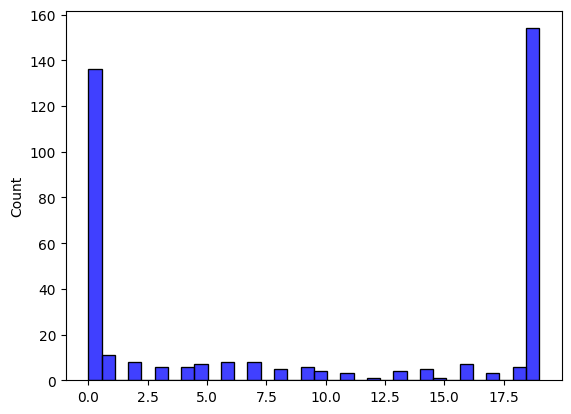

In [33]:
tfs.get_distribution_number_of_edges_per_nodes("cpu",My_dictionary, threashold, vectores_places)

 total amount of edges : 6275


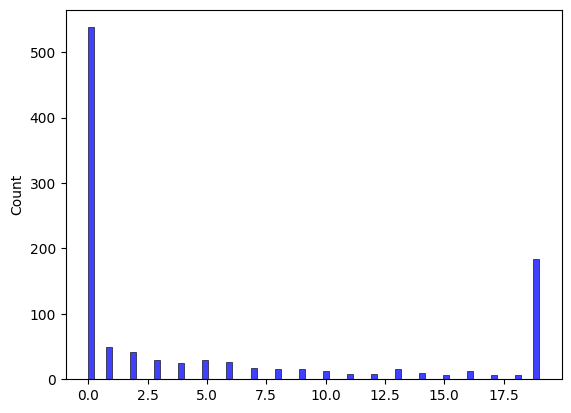

In [34]:
new_distrib=tfs.get_distribution_number_of_edges_per_nodes("server",My_dictionary,threashold, vectores_places)

In [35]:
tfs.plot_only_part_data(My_dictionary,threashold,vectores_places,"server_1")

 total amount of edges : 475


In [36]:
useless1,useless2,useless2, edges_complet=tfs.get_edges_v3(My_dictionary,threashold,vectores_places,"cpu")
med2=tfs.get_medium_number_of_edges(edges_complet)
print(med2)

 total amount of edges : 4004
13.148409893992932


# IV) This section build the adjacency matrix that we willl use in GNN

In [37]:
adj_25=tfs.build_adjacency_matrix_v2(edges_complet_25[1:],corr_mat)

In [38]:
adj_3d=tfs.build_adjacency_matrix_v2(edges_complet[1:],corr_mat)

In [39]:
adj_3np=np.array(adj_3d)
adj_25np=np.array(adj_25)

diff_adj=adj_25np-adj_3np

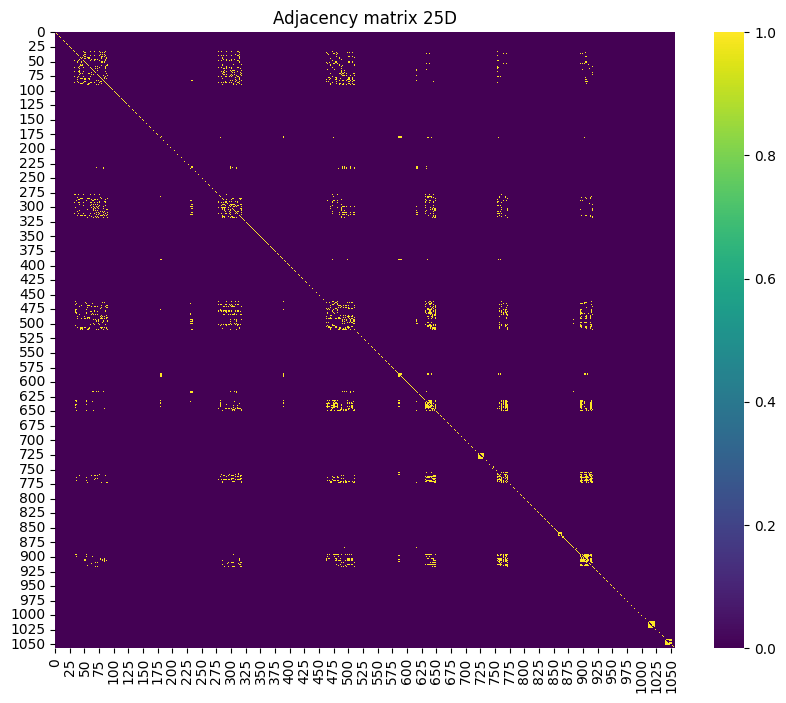

In [40]:
#visualize the matrix:

downsampled_data = adj_3np[::1, ::1]  # we can downsample if we prefer

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(downsampled_data, cmap='viridis')
plt.title('Adjacency matrix 25D')
plt.show()

> ### We made 2 differents models for words, one words projected in 25 dimensions, the other in 3, now we compare the two matrix

In [41]:
sc=tfs.divergence_matrix(adj_3np, adj_25np)
# in percent : 
sc_p=100*sc
print(sc_p)

1.6776922601855093


# V) Finaly we have to save/load the matrix

Modify the path for saving in the right place

In [ ]:
np.savetxt('/home/student/Documents/Data/Training_Set_Day_1/adj3d_th09.csv',adj_3np, delimiter=',')
np.savetxt('/home/student/Documents/Data/Training_Set_Day_1/adj25d_th09.csv',adj_25np, delimiter=',')

In [ ]:
#Here is how to load after
t1=np.genfromtxt('/home/student/Documents/Data/Training_Set_Day_1/adj3d_th09.csv', delimiter=',')